# Explanation of this notebook

explain...

The following things are interesting to dive further into:

1. which landing page is most frequent one - compared to the leads? 
2. where does the closed deals primarily come from (origin) - compared to the leads?
3. how long time is the average closing? 
4. are there periods which is better to contact leads?
5. how many closed customers does already have a declared monthly revenue and what does the total closed deals sellers looks like in terms of type, segments etc. 
6. which SDR is best overall 
7. which SDR/SR is best at talking to different leads
8. which SDR/SR is the fastest one

# <font color='blue'>Setup 1</font>: Load Libraries

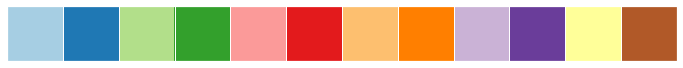

In [237]:
import numpy as np
import pandas as pd
import sys, os
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
sns.set()
sns.palplot(sns.color_palette("Paired"))
plt.rcParams['figure.figsize'] = (20.0, 6.0)
plt.style.use('ggplot')

# <font color='blue'>Setup 2</font>: Load data

In [2]:
def load_table(tablename):
    """ Defining the current directory and path to where data are located. Joining path to
    data folder and table name in order to read the table into a Pandas DataFrame"""
    
    file_path = os.path.join ('../data/') 

    df = os.path.join(file_path, tablename) 
    df = pd.read_csv(df, sep=',', encoding="latin1") 
    
    return df

In [3]:
# Reading the olist_marketing_qualified_leads table
leads = load_table('olist_marketing_qualified_leads_dataset.csv')
leads.head()

,mql_id,first_contact_date,landing_page_id,origin
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search
3,6be030b81c75970747525b843c1ef4f8,2018-01-22,d45d558f0daeecf3cccdffe3c59684aa,email
4,5420aad7fec3549a85876ba1c529bd84,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search


In [4]:
#Reading the olist_closed_deals table
closed_leads = load_table('olist_closed_deals_dataset.csv')
closed_leads.head()

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0
1,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,NaN,NaN,NaN,reseller,NaN,0.0
2,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0
3,f5fee8f7da74f4887f5bcae2bafb6dd6,21e1781e36faf92725dde4730a88ca0f,56bf83c4bb35763a51c2baab501b4c67,d3d1e91a157ea7f90548eef82f1955e3,2018-01-17 13:51:03,food_drink,online_small,NaN,NaN,NaN,NaN,reseller,NaN,0.0
4,ffe640179b554e295c167a2f6be528e0,ed8cb7b190ceb6067227478e48cf8dde,4b339f9567d060bcea4f5136b9f5949e,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances,industry,wolf,NaN,NaN,NaN,manufacturer,NaN,0.0


# <font color='blue'>Part 1</font>: Descriptive analysis

In terms of providing some context, the following discription is taken from the documentation:
> A seller join Olist through a marketing and sales funnel that was made public at this dataset. Description of steps:
1. After a lead fills in a form at a landing page, a filter is made to select the ones that are qualified to sell their products at Olist. They are the Marketing Qualified Leads (MQLs).
2. Then the Marketing Qualified Leads (MQLs) is contacted by a Sales Development Representative. (SDR), confirm some information and schedule a consultancy.
3. Consultancy is made by a Sales Representative (SR). The SR may close the deal (lead sing up) or lose the deal (led leaves without sign in)
4. Lead becomes a seller and starts building his catalog on Olist. His products are published on marketplaces and ready to sell!

In [5]:
def land_page_map(df):
    land_page_dict = {}
    ID = 0
    for page in df['landing_page_id'].unique():
        land_page_dict[page] = ID
        ID += 1
        
    return land_page_dict

page_id_map = land_page_map(leads)

In [6]:
def create_mapping_column(df):
    plot_id = []
    for i in df['landing_page_id']:
        plot_id.append(page_id_map.get(i))
    
    return plot_id

In [7]:
def plot_timeline(df, pct = True, log = False, origin = True):
    sns.set_palette(sns.color_palette("Paired"))
    
    series = pd.DataFrame(df,columns = ['first_contact_date','origin'])
    series['freq'] = series.groupby(['first_contact_date','origin'])['first_contact_date'].transform('count')
    series = series.drop_duplicates()
    
    new = series["first_contact_date"].str.split("-", n = 2, expand = True)
    series['first_contact_month'] = new[0]+'-'+new[1]+'-'+'01'
    
    series = series.groupby(['first_contact_month','origin'])['freq'].agg('sum').reset_index()
    
    series['log_value'] = np.log(series['freq'])
    series['log2_value'] = np.log2(series['freq'])
    series['percentage'] = series['freq']/len(df)
    series['first_contact_month'] = pd.to_datetime(series.first_contact_month)
    
    if origin == True:
        
        if pct == True:
            sns.lineplot(data=series,x='first_contact_month',y='percentage',hue='origin',err_style=None)
            plt.title('Frequency over time by type of media where the lead was aquired')
            plt.ylabel('Frequency (%)', fontsize=12)
            plt.xlabel('Date', fontsize=12)
            plt.show()
        
        else:
            if log == True:
                sns.lineplot(data=series,x='first_contact_month',y='log_value',hue='origin',err_style=None)
                plt.title('Log value of frequency over time by type of media where the lead was aquired')
                plt.ylabel('Log value of frequency', fontsize=12)
                plt.xlabel('Date', fontsize=12)
                plt.show()
                
            else:
                sns.lineplot(data=series,x='first_contact_month',y='freq',hue='origin',err_style=None)
                plt.title('Frequency over time by type of media where the lead was aquired')
                plt.ylabel('Frequency', fontsize=12)
                plt.xlabel('Date', fontsize=12)
                plt.show()
    
    else:
        sns.lineplot(data=series,x='first_contact_month',y='freq',err_style=None)
        plt.title('Frequency over time where the lead was aquired')
        plt.ylabel('Frequency', fontsize=12)
        plt.xlabel('Date', fontsize=12)
        plt.show()     
        

In [8]:
def plot_origin(df, year=True):
    sns.set_palette(sns.color_palette("Paired"))
    
    series = pd.DataFrame(df,columns = ['first_contact_date','origin'])
    series['freq'] = series.groupby(['first_contact_date','origin'])['origin'].transform('count')
    series = series.drop_duplicates()
    
    new = series["first_contact_date"].str.split("-", n = 2, expand = True)
    series['first_contact_year'] = new[0]
    
    series = series.groupby(['first_contact_year','origin'])['freq'].agg('sum').reset_index()
    series['percentage'] = round(series['freq']/len(df),2)
    
    if year==True:
        sns.barplot(data=series, x='origin',y='percentage' , alpha=0.8, hue='first_contact_year')
        plt.title('Frequency by year of the type of media where the lead was aquired')
        plt.ylabel('Frequency (%)', fontsize=12)
        plt.xlabel('Origin', fontsize=12)
        plt.show()
    else:
        sns.barplot(data=series, x='origin',y='percentage' , alpha=0.8)
        plt.title('Frequency of the type of media where the lead was aquired')
        plt.ylabel('Frequency (%)', fontsize=12)
        plt.xlabel('Origin', fontsize=12)
        plt.show()

In [9]:
def plot_top_n_land_page(df, n):
    sns.set_palette(sns.color_palette("Paired"))
    
    series = pd.DataFrame(df,columns = ['landing_page_id'])
    series['plot_id'] = create_mapping_column(df)
    
    series['freq'] = series['plot_id'].map(series['plot_id'].value_counts())
    series = series.groupby(['landing_page_id','plot_id'])['freq'].agg('max').reset_index()
    series = series.sort_values(by=['freq'],ascending=False)
    series['percentage'] = round(series['freq']/len(df),2)
    page_count = series[:n]
    
    sns.barplot(data=page_count, x='plot_id', y='percentage', order=page_count['plot_id'], alpha=0.8)
    plt.title('Top 10 frequency of landing page id where the lead was aquired')
    plt.ylabel('Frequency (%)', fontsize=12)
    plt.xlabel('Landing page id', fontsize=12)
    plt.show()
    
    print(page_count)

In [10]:
def plot_closed_vs_not(df1, df2):
    sns.set_palette(sns.color_palette("Paired"))
    
    series = pd.DataFrame(df1,columns = ['mql_id','origin'])
    ids = [x for x in df2.mql_id]
    series['closed'] = ['Closed' if x in ids else 'Not closed' for x in series.mql_id]
    series['freq'] = series.groupby(['origin','closed'])['origin'].transform('count')
    series = series.drop_duplicates()
    
    series = series.groupby(['origin','closed'])['freq'].agg('max').reset_index()
    series['percentage'] = np.where(series['closed']=='Not closed', round(series['freq']/len(df1),2), round(series['freq']/len(df2),2))
    
    sns.barplot(data=series, x='origin',y='percentage', hue='closed', alpha=0.8)
    plt.title('Closed vs Not closed by the type of media where the lead was aquired')
    plt.ylabel('Frequency (%)', fontsize=12)
    plt.xlabel('Origin', fontsize=12)
    plt.show() 

## <font color='blue'>1.1</font>:  The olist marketing qualified leads dataset

In [11]:
leads.describe()

,mql_id,first_contact_date,landing_page_id,origin
count,8000,8000,8000,7940
unique,8000,336,495,10
top,4b86f03081bd4d9cfc59e51fccb9eb45,2018-05-02,b76ef37428e6799c421989521c0e5077,organic_search
freq,1,93,912,2296


In the olist marketing qualified leads dataset we find 8.000 unique marketing qualified leads. Those 8.000 leads was acquired on 495 unique landing pages spread out on 336 unique contact dates. The landing pages can be categorised into 10 types of media where the lead was acquired. The first lead was acquired 06-14-2017 and the latest 05-31-2018.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


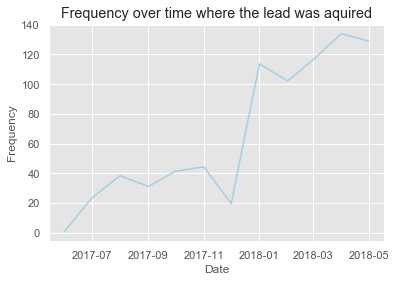

In [12]:
plot_timeline(leads, pct = False, log = False, origin = False)

Between November 2017 and January 2018 we see a significant rise in acquired marketing qualified leads. 

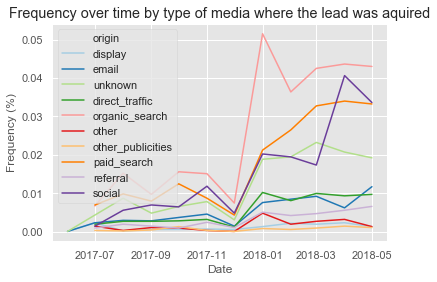

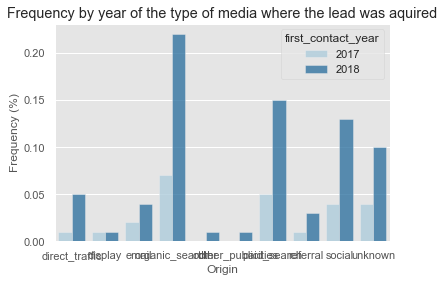

In [13]:
plot_timeline(leads, pct = True, log = False, origin = True)
plot_origin(leads, year=True)

This increase is primarily attributable to the use of the media types `organic_search`, `paid_search` and `social`.

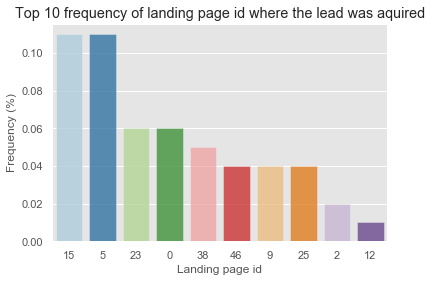

                      landing_page_id  plot_id  freq  percentage
356  b76ef37428e6799c421989521c0e5077       15   912        0.11
61   22c29808c4f815213303f8933030604c        5   883        0.11
159  58326e62183c14b0c03085c33b9fdc44       23   495        0.06
262  88740e65d5d6b056e0cda098e1ea6313        0   445        0.06
394  ce1a65abd0973638f1c887a6efcfa82d       38   394        0.05
122  40dec9f3d5259a3d2dbcdab2114fae47       46   330        0.04
468  f017be4dbf86243af5c1ebed0cff36a2        9   310        0.04
443  e492ee5eaf1697716985cc6f33f9cd9b       25   291        0.04
321  a7982125ff7aa3b2054c6e44f9d28522        2   156        0.02
228  73f31a40697cc90a86c1273563ac230e       12   115        0.01


In [14]:
plot_top_n_land_page(leads,10)

Over 20% of the marketing qualified leads are acquired through the landing pages *b76ef37428e6799c421989521c0e5077* and *22c29808c4f815213303f8933030604c*

## <font color='blue'>1.2</font>:  The olist marketing qualified leads joined with the closed deals dataset

The two tables are then merged, so that we can obtain insights on the closed deals and compare this to the leads. 

In [15]:
closed_leads = closed_leads.merge(leads, on="mql_id", how= "left")

In [16]:
closed_leads.describe(include=['O'])

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,first_contact_date,landing_page_id,origin
count,842,842,842,842,842,841,836,665,63,64,66,832,842,842,828
unique,842,842,32,22,824,33,8,9,2,2,6,3,195,134,10
top,d6137197f40a5b7916e5e9cbbbab739e,6e1706430e9dda78c8d2d5dd1f36d545,4b339f9567d060bcea4f5136b9f5949e,4ef15afb4b2723d8f3d81e51ec7afefe,2018-05-04 03:00:00,home_decor,online_medium,cat,True,True,5-20,reseller,2018-02-06,22c29808c4f815213303f8933030604c,organic_search
freq,1,1,140,133,6,105,332,407,58,54,22,587,14,174,271


In the joined dataset we find 842 unique closed leads. I.e. out of the 8.000 marketing qualified leads only ~10% was closed. The 842 closed leads was contacted by one of 32 sales development representatives (SDR), while the consultancy was provided by 22 different sales representatives (SR). The `sellers` are categorised into 33 different `business_segment`, 3 `business_type`, 8 `lead_type` and 9 `lead_behaviour_profile`. Furthermore, an `average_stock`, `declared_product_catalog_size` and `declared_monthly_revenue` is occasionally noted. The first lead was closed 12-05-2017 and the latest 11-14-2018.

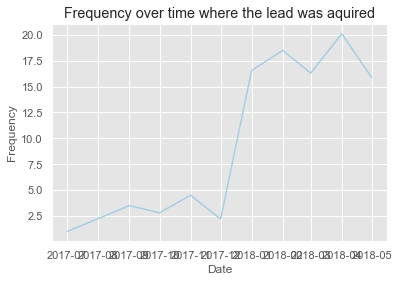

In [17]:
plot_timeline(closed_leads, pct = False, log = False, origin = False)

Between November 2017 and January 2018 we see the same significant rise in acquired marketing qualified leads. 

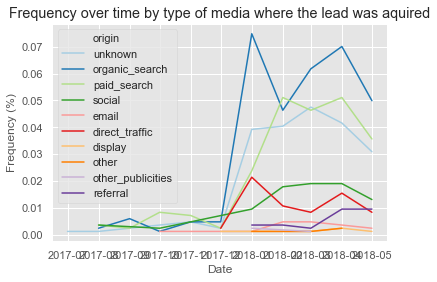

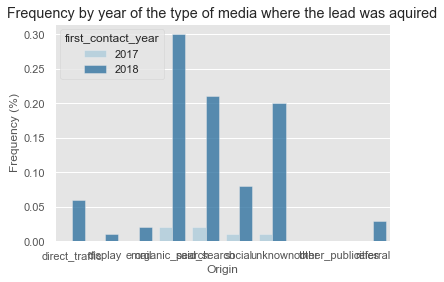

In [18]:
plot_timeline(closed_leads, pct = True, log = False, origin = True)
plot_origin(closed_leads, year=True)

This increase is again primarily attributable to the use of the media types `organic_search`, `paid_search` and `social`.

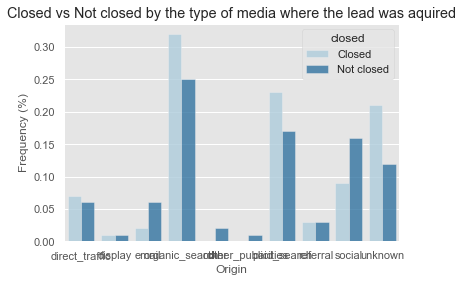

In [19]:
plot_closed_vs_not(leads, closed_leads)

But this time we see that `organic_search` and `paid_search` is much more effect. Their importance is respectively ~6 and ~7 percentage point more significant.

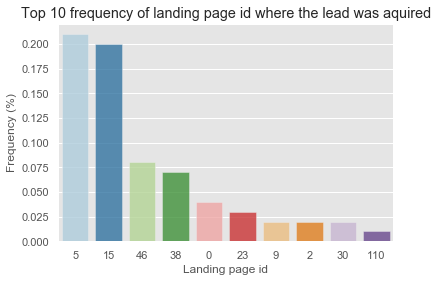

                      landing_page_id  plot_id  freq  percentage
23   22c29808c4f815213303f8933030604c        5   174        0.21
95   b76ef37428e6799c421989521c0e5077       15   171        0.20
44   40dec9f3d5259a3d2dbcdab2114fae47       46    67        0.08
106  ce1a65abd0973638f1c887a6efcfa82d       38    59        0.07
77   88740e65d5d6b056e0cda098e1ea6313        0    31        0.04
50   58326e62183c14b0c03085c33b9fdc44       23    27        0.03
126  f017be4dbf86243af5c1ebed0cff36a2        9    21        0.02
86   a7982125ff7aa3b2054c6e44f9d28522        2    18        0.02
24   241f79c7a8fe0270f4fb79fcbbcd17ad       30    14        0.02
68   7fa6214d82e911d070f51ef79381b956      110    11        0.01


In [20]:
plot_top_n_land_page(closed_leads,10)

This time over 40% of the closed marketing qualified leads are acquired through the landing pages *b76ef37428e6799c421989521c0e5077* and *22c29808c4f815213303f8933030604c*

## <font color='blue'>1.3</font>:  How long is the average period for closing a seller

In [21]:
#Checking whether the columns are datetimes
print(type(closed_leads.first_contact_date[0]))
print(type(closed_leads.won_date[0]))

<class 'str'>
<class 'str'>


In [22]:
#Changing these columns to datetimes
closed_leads.first_contact_date = pd.to_datetime(closed_leads.first_contact_date)
closed_leads.won_date = pd.to_datetime(closed_leads.won_date)

In [23]:
#Making an overview of the period from initial contact to closed deal
closed_leads["closing_period"] = closed_leads.won_date-closed_leads.first_contact_date

In [24]:
#Assessing the result from the operation. 
closed_leads.closing_period.head()

0     5 days 19:58:54
1    34 days 20:17:59
2    63 days 17:27:23
3     3 days 13:51:03
4   267 days 20:17:45
Name: closing_period, dtype: timedelta64[ns]

Since we have now obtained the time difference from when the initial contact was made until the closing, we are now able to use this datastrucutre to plot the distribution. 

In [25]:
#Example od a datastructure:
print("This is how the data is formatted: ",closed_leads.closing_period[0])
print("This is the period plotted: ", closed_leads.closing_period.values[0]/np.timedelta64(1, 'D'))

This is how the data is formatted:  5 days 19:58:54
This is the period plotted:  5.832569444444444


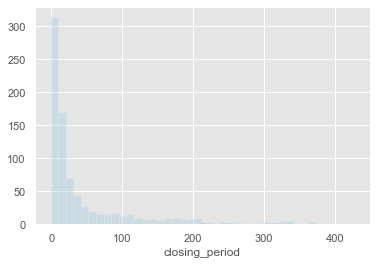

In [26]:
sns.distplot(closed_leads.closing_period/np.timedelta64(1, 'D'),bins=40, kde = False);

## <font color='blue'>1.4</font>:  Are there periods where it seems more appropriate to contact the leads than others? 

This question is answered by looking at the leads dataset in comparison with all the closed sellers

In [27]:
#First, the format of the first_contact_date column in the lead dataset is also transformed into datetimes
leads.first_contact_date = pd.to_datetime(leads.first_contact_date)

In [28]:
#In both datasets, we are making a distinct column which holds the month where the seller was contacted
closed_leads["Month_contacted"] = closed_leads.first_contact_date.dt.month
leads["month_contacted"] = leads.first_contact_date.dt.month

In [29]:
#Then we make a variable which hold the data to be plotted:
pct_closed_per_month = closed_leads.groupby(closed_leads["first_contact_date"].dt.month).count().Month_contacted/len(closed_leads)
pct_leads_per_month = leads.groupby(leads["first_contact_date"].dt.month).count().month_contacted/len(leads)

In [30]:
#And put these new variables into a dataframe, so that we can plot these two columns together in the same barchart
months_overview = pd.DataFrame(pct_closed_per_month)
months_overview.columns=["Closed leads contacted"]
months_overview["Leads contacted"] = pct_leads_per_month

In [31]:
months_overview

,Closed leads contacted,Leads contacted
first_contact_date,,
1,0.180523,0.142625
2,0.176960,0.128500
3,0.198337,0.146750
4,0.217340,0.169000
5,0.154394,0.162875
7,0.002375,0.029875
8,0.010689,0.048250
9,0.008314,0.039000
10,0.016627,0.052000


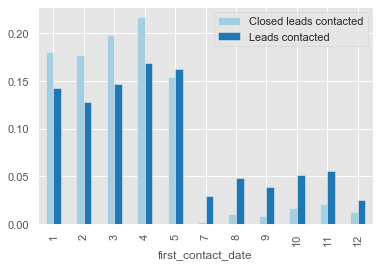

In [32]:
months_overview.plot.bar();

## <font color='blue'>1.5</font>:  How many customers does already have a declaired revenue? And what type of business are they?

In [33]:
print("The number of closed companies are: ", len(closed_leads), "\n", \
      "Of all the closed leads the following amount already had a declaired revenue: ", len(closed_leads[closed_leads.declared_monthly_revenue>0]), "\n", \
     "Which amounts to ", len(closed_leads[closed_leads.declared_monthly_revenue>0])/len(closed_leads)*100,"% of the total closed leads")

The number of closed companies are:  842 
 Of all the closed leads the following amount already had a declaired revenue:  45 
 Which amounts to  5.344418052256532 % of the total closed leads


##### The total distribution and exploration of the lead type, business type and business segment

In [34]:
#Defining a pandas with only relevant metrics
business_types = closed_leads[["business_segment", "lead_type", "business_type"]]

In [35]:
#Assessing whether they hold nan values (some of them does)
business_types.isnull().sum()

business_segment     1
lead_type            6
business_type       10
dtype: int64

In [36]:
segment = business_types.business_segment.value_counts()
l_type = business_types.lead_type.value_counts()
b_type = business_types.business_type.value_counts()

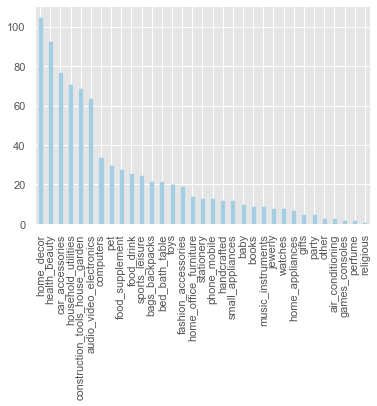

In [37]:
segment.plot.bar();

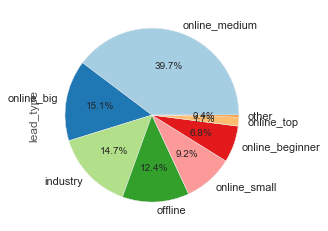

In [38]:
l_type.plot.pie(title=None, autopct='%1.1f%%');

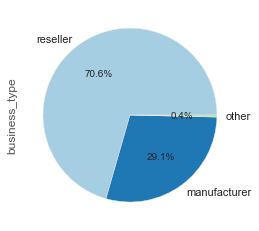

In [39]:
b_type.plot.pie(autopct='%1.1f%%');

## <font color='blue'>1.6</font>:  Looking at the SR (and maybe SDR later)

A Sales Development Representative is one having the initial contact witht the company, right after the company has signed up on the landing page. The SDR is noting some general information and arranging a meeting for when the business can meet a Sales Representative who may win or lose the deal.

In general, it is quite difficult to say whether a SR and SDR is good, relative to how many deals they did not close. However, since the SR's and SDR's are not present in the MQL dataset, it is not possible to measure their actual performance agains the number of lost deals. 
Therefore, we assume they have a steady stream of contact with potential sellers, and that some SR's and SDR's are just better at closing the sellers than other SR's and SDR's. 

The following distributions of the rate of closed customers can then be used to address how potentially high value sellers should be contacted and **by who**. 

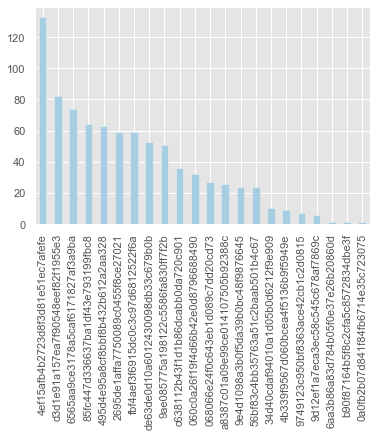

In [40]:
closed_leads.sr_id.value_counts().plot.bar();

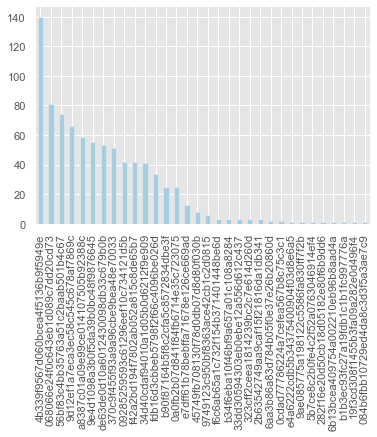

In [41]:
closed_leads.sdr_id.value_counts().plot.bar();

##### Looking at every individual SR and what sellers they are closing in terms of business segments and lead type

In [42]:
#Creating a dataframe holding the different business segments
df_seg = closed_leads.groupby(["sr_id","business_segment"]).count().seller_id.reset_index(name="count")

In [43]:
#Ordering the data properly and removing nan values
df_seg = df_seg.pivot(index= "sr_id", columns= "business_segment", values= "count")
df_seg = df_seg.fillna(0)

In [44]:
#Creating a total column to order the data for later plotting. After ordering, the total column is dropped
df_seg["total"] = df_seg.sum(axis=1)
df_seg = df_seg.sort_values("total",ascending= True)
df_seg = df_seg.drop(["total"],axis=1)

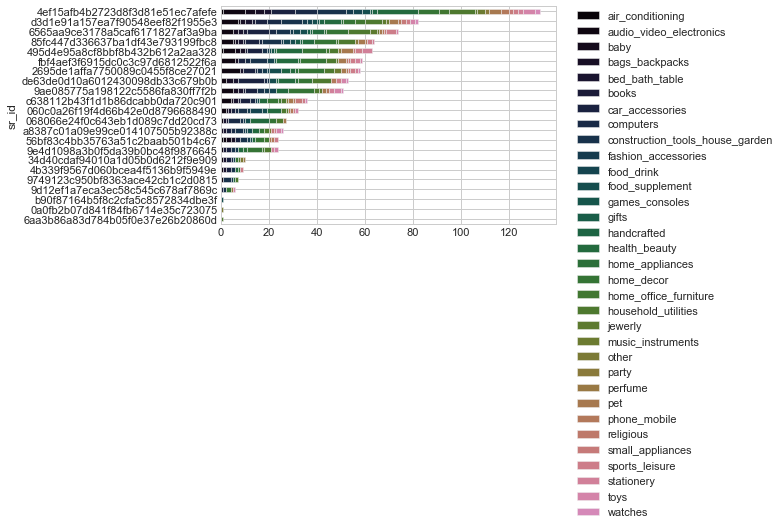

In [45]:
plt.style.use(['seaborn-whitegrid'])
sns.set_palette("cubehelix",50)
df_seg.plot.barh(stacked= True).legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

In [46]:
#Same procedure with lead type:
df_lead = closed_leads.groupby(["sr_id","lead_type"]).count().seller_id.reset_index(name="count")

df_lead = df_lead.pivot(index= "sr_id", columns= "lead_type", values= "count")
df_lead = df_lead.fillna(0)

df_lead["total"] = df_lead.sum(axis=1)
df_lead = df_lead.sort_values("total",ascending= True)
df_lead = df_lead.drop(["total"],axis=1)

In [47]:
plt.style.use(['seaborn-whitegrid'])
sns.set_palette("cubehelix",10)

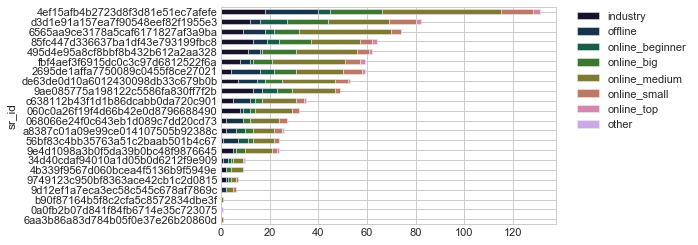

In [48]:
df_lead.plot.barh(stacked= True).legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

The plot proves a very important point, namely that the different SR's does not get specific business segments, which could potentially be easier to close. However, they are all recieving a variety of different segments and lead types, which indicate that some SR's are just inherintly better at closing the sellers. 

##### Look at the landing page in combination with origin. This way we can make some kind of probability for closing the customer, from the data we have available - since this is the only features that both datasets have in common. 

# !!!! see above !!!!

## <font color='blue'>1.7</font>:  Conclusion on descriptive

## <font color='blue'>Part 2</font>: Prediction- what sellers will be profitable?

### Assumption: 
*Whether a seller sells 40 items a month or 400 items a month, Olist can store, pack, and ship their items while only retaining 10–15% of each transaction.*

**Therefor, a profitable seller either many items, sells items to a high price or do both.**

        We create a prediction rule to tell a sellers weekly average turnover.

## <font color='blue'>2.1</font>:  Missing values

Missing values can cause errors in algorithms and real world data often has missing values.

First of all, there is no "good-way" to handle missing values. But in general there is three methods to handle missing values.

1. Remove rows or columns containing missing values
    - This is the simplest method for handling missing values. 
        - Pro's: easy too handle and doesn't add noise to data. 
        - Con's: can be too limiting for some datasets, i.e. removing too much information.
        
2. Impute missing values
    - Refers to the act of replacing the missing values with the mean, median, mode, a constant etc.
        - Pro's: we keep information, though adding some noise.
        - Con's: maybe missing values have a meaning?
        
3. Predict missing values
    - Refers to the act of imputing missing values by using a prediction rule .
        - Pro's: we keep information and approximates the missing values to the "true" information.
        - Con's: maybe missing values have meaning and the approximated "true" information get too biased.


In order to choose a meaningful approach, we need to get an overview of the missing values.

In [49]:
def count_missing_values(df):
    missing = df.isna()
    num_missing = pd.DataFrame(missing.sum(),columns=['Number'])
    num_missing['Percentage'] = round(num_missing / len(df),2)
    
    print(num_missing)

In [50]:
show_nans= lambda df: df[df.isnull().any(axis=1)]

In [51]:
count_missing_values(closed_leads)

                               Number  Percentage
mql_id                              0        0.00
seller_id                           0        0.00
sdr_id                              0        0.00
sr_id                               0        0.00
won_date                            0        0.00
business_segment                    1        0.00
lead_type                           6        0.01
lead_behaviour_profile            177        0.21
has_company                       779        0.93
has_gtin                          778        0.92
average_stock                     776        0.92
business_type                      10        0.01
declared_product_catalog_size     773        0.92
declared_monthly_revenue            0        0.00
first_contact_date                  0        0.00
landing_page_id                     0        0.00
origin                             14        0.02
closing_period                      0        0.00
Month_contacted                     0        0.00


If the column contains 85% missing values then we choose to drop the column. Meaning we are dropping the columns `has_company`, `has_gtin`, `average_stock` and `declared_product_catalog_size`.

In [52]:
closed_leads = closed_leads.drop(['has_company'], axis=1)
closed_leads = closed_leads.drop(['has_gtin'], axis=1)
closed_leads = closed_leads.drop(['average_stock'], axis=1)
closed_leads = closed_leads.drop(['declared_product_catalog_size'], axis=1)

In [53]:
count_missing_values(closed_leads)

                          Number  Percentage
mql_id                         0        0.00
seller_id                      0        0.00
sdr_id                         0        0.00
sr_id                          0        0.00
won_date                       0        0.00
business_segment               1        0.00
lead_type                      6        0.01
lead_behaviour_profile       177        0.21
business_type                 10        0.01
declared_monthly_revenue       0        0.00
first_contact_date             0        0.00
landing_page_id                0        0.00
origin                        14        0.02
closing_period                 0        0.00
Month_contacted                0        0.00


Regarding the coloumns `lead_behaviour_profile`, `business_segment`, `lead_type`, `business_type` and `origin`  we have a total of 308 missing values. Since we are not interested in dropping neither the columns or 36% of our observations, we choose to replace missing values with the their respectively category for *unknown* observations. I.e. we interpret the missing values of being either an *unknown* or *other* observation.

In [54]:
closed_leads['lead_behaviour_profile'] = closed_leads['lead_behaviour_profile'].fillna('unknown')
closed_leads['origin'] = closed_leads['origin'].fillna('unknown')
closed_leads['business_segment'] = closed_leads['business_segment'].fillna('other')
closed_leads['lead_type'] = closed_leads['lead_type'].fillna('other')
closed_leads['business_type'] = closed_leads['business_type'].fillna('other')

In [55]:
show_nans(closed_leads)

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,business_type,declared_monthly_revenue,first_contact_date,landing_page_id,origin,closing_period,Month_contacted


In [87]:
count_missing_values(closed_leads)

                          Number  Percentage
mql_id                         0         0.0
seller_id                      0         0.0
sdr_id                         0         0.0
sr_id                          0         0.0
won_date                       0         0.0
business_segment               0         0.0
lead_type                      0         0.0
lead_behaviour_profile         0         0.0
business_type                  0         0.0
declared_monthly_revenue       0         0.0
first_contact_date             0         0.0
landing_page_id                0         0.0
origin                         0         0.0
closing_period                 0         0.0
Month_contacted                0         0.0
closing_period_days            0         0.0


## <font color='blue'>2.2</font>: Feature extraction

#### *Closing period days*

In [57]:
closed_leads["closing_period_days"] = closed_leads.closing_period.values/np.timedelta64(1, 'D')

In [59]:
#Changing these columns to datetimes
closed_leads.first_contact_date = pd.to_datetime(closed_leads.first_contact_date)
closed_leads.won_date = pd.to_datetime(closed_leads.won_date)

In [60]:
#Making an overview of the period from initial contact to closed deal
closed_leads["closing_period"] = closed_leads.won_date-closed_leads.first_contact_date

In [61]:
#Changing these columns to datetimes
closed_leads.first_contact_date = pd.to_datetime(closed_leads.first_contact_date)
closed_leads.won_date = pd.to_datetime(closed_leads.won_date)

#Making an overview of the period from initial contact to closed deal
closed_leads["closing_period"] = closed_leads.won_date-closed_leads.first_contact_date

Since a closing period can't be negative, we check if the feature extraction is done correctly.

In [62]:
closed_leads[closed_leads.closing_period.values/np.timedelta64(1, 'D')<0]

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,business_type,declared_monthly_revenue,first_contact_date,landing_page_id,origin,closing_period,Month_contacted,closing_period_days
667,b91cf8812365f50ff4bda4bcd6206b05,5e063e85d44b0f5c3e6ec3131103a57e,a8387c01a09e99ce014107505b92388c,495d4e95a8cf8bbf8b432b612a2aa328,2018-03-06 19:38:55,health_beauty,online_big,cat,reseller,0.0,2018-03-08,4aab772aeb9833c170d8ea5413e02eac,organic_search,-2 days +19:38:55,3,-1.181308


The feature extraction seems to been done correctly. However, one observation contains an impossible `won_date`. Therefor we choose to remove this observation from our dataset.

In [63]:
closed_leads = closed_leads.drop(667)

#### *weekly average turnover*

In [130]:
all_orders = load_table("olist_order_items_dataset.csv")
all_orders.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


In [131]:
all_orders.describe(include='O')

,order_id,product_id,seller_id,shipping_limit_date
count,112650,112650,112650,112650
unique,98666,32951,3095,93318
top,8272b63d03f5f79c56e9e4120aec44ef,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,2017-07-21 18:25:23
freq,21,527,2033,21


In [132]:
print(np.round((1-(98666/112650))*100,2),'% of the orders includes more than 1 item')

12.41 % of the orders includes more than 1 item


In [135]:
all_orders = load_table("olist_order_items_dataset.csv")
all_orders['shipping_limit_date'] = pd.to_datetime(all_orders['shipping_limit_date'])
total_revenue = all_orders.groupby(['seller_id'])['price'].agg('sum').reset_index()

In [137]:
all_orders['shipping_limit_date'] = pd.to_datetime(all_orders['shipping_limit_date'])
all_orders['time_as_seller'] = all_orders['shipping_limit_date'].max() - all_orders['shipping_limit_date']
all_orders['weeks_as_seller'] = all_orders['time_as_seller'].dt.days/7

In [138]:
all_orders.head() 

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,time_as_seller,weeks_as_seller
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,933 days 12:49:33,133.285714
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,1072 days 11:29:55,153.142857
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,812 days 07:46:38,116.000000
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,603 days 12:24:50,86.142857
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,1151 days 08:37:17,164.428571


In [140]:
all_orders = all_orders.groupby(['seller_id'])['weeks_as_seller'].agg('max').reset_index()

In [149]:
sellers = all_orders.merge(total_revenue, on="seller_id", how= "left")

In [150]:
sellers['weekly_avg_revenue']=sellers.price/sellers.weeks_as_seller

In [151]:
sellers.describe()

,weeks_as_seller,price,weekly_avg_revenue
count,3095.000000,3095.000000,3095.000000
mean,127.825987,4391.484233,30.928104
std,28.362946,13921.997192,90.955381
min,83.428571,3.500000,0.023048
25%,102.000000,208.850000,1.857733
50%,125.857143,821.480000,6.921552
75%,153.357143,3280.830000,24.500868
max,185.428571,229472.630000,1639.781651


## <font color='blue'>2.3</font>: Prediction

In [183]:
data = closed_leads.merge(sellers, on='seller_id', how="inner")
data = data.drop('weeks_as_seller',axis=1)
data = data.drop('price',axis=1)

In [184]:
data

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,business_type,declared_monthly_revenue,first_contact_date,landing_page_id,origin,closing_period,Month_contacted,closing_period_days,weekly_avg_revenue
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,reseller,0.0,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search,5 days 19:58:54,2,5.832569,9.197550
1,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,reseller,0.0,2018-04-03,1ceb590cd1e00c7ee95220971f82693d,organic_search,63 days 17:27:23,4,63.727350,243.155331
2,ffe640179b554e295c167a2f6be528e0,ed8cb7b190ceb6067227478e48cf8dde,4b339f9567d060bcea4f5136b9f5949e,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances,industry,wolf,manufacturer,0.0,2017-10-09,a0fbc0263cb98bdb0d72b9f9f283a172,unknown,267 days 20:17:45,10,267.845660,6.443820
3,b94fba7670eeb44dce2a0d8eb790e9f5,1c742ac33582852aaf3bcfbf5893abcf,fdb16d3cbbeb5798f2f66c4096be026d,495d4e95a8cf8bbf8b432b612a2aa328,2018-02-07 18:04:05,health_beauty,online_medium,unknown,manufacturer,0.0,2018-02-06,40dec9f3d5259a3d2dbcdab2114fae47,organic_search,1 days 18:04:05,2,1.752836,1.052688
4,b02c89251106e1fdd9d92744be9f94f2,44ed138eca6214d572ce1d813fb0049b,34d40cdaf94010a1d05b0d6212f9e909,4ef15afb4b2723d8f3d81e51ec7afefe,2018-04-17 17:01:57,health_beauty,offline,cat,manufacturer,0.0,2018-04-13,b76ef37428e6799c421989521c0e5077,unknown,4 days 17:01:57,4,4.709688,1.504189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,98826328c3a60215e53b342560084571,f46490624488d3ff7ce78613913a7711,9d12ef1a7eca3ec58c545c678af7869c,068066e24f0c643eb1d089c7dd20cd73,2018-05-16 19:51:05,health_beauty,online_big,eagle,reseller,0.0,2018-04-04,73f31a40697cc90a86c1273563ac230e,other,42 days 19:51:05,4,42.827141,59.647504
375,245710681d51a6dfb80ab06683f3be01,7c9130f5f3729edd32aa059141d92484,370c9f455f93a9a96cbe9bea48e70033,4ef15afb4b2723d8f3d81e51ec7afefe,2018-05-07 21:49:28,computers,other,unknown,reseller,0.0,2018-04-23,b76ef37428e6799c421989521c0e5077,organic_search,14 days 21:49:28,4,14.909352,1.350689
376,cd803c8ab3c2afa5430eeb195bcebe6a,33dd941c27854f7625b968cc6195a552,a8387c01a09e99ce014107505b92388c,85fc447d336637ba1df43e793199fbc8,2018-03-28 22:42:55,household_utilities,online_medium,cat,reseller,0.0,2018-03-27,c494978688ccf66ad9fad3d6a3338c22,email,1 days 22:42:55,3,1.946470,70.077434
377,676207ddcc8087437135a4b461fc07cb,c70a353f02429c00775a46a75fb787da,370c9f455f93a9a96cbe9bea48e70033,4ef15afb4b2723d8f3d81e51ec7afefe,2018-04-20 12:27:44,health_beauty,online_medium,cat,reseller,0.0,2018-04-08,58326e62183c14b0c03085c33b9fdc44,social,12 days 12:27:44,4,12.519259,2.714744


In [186]:
def label_encode(data, column): 
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    
    le.fit(data[column])
    data[column] = le.transform(data[column])
    
    return data

In [187]:
data = label_encode(data, 'business_segment')
data = label_encode(data, 'lead_type')
data = label_encode(data, 'lead_behaviour_profile')
data = label_encode(data, 'business_type')
data = label_encode(data, 'landing_page_id')
data = label_encode(data, 'origin')

In [189]:
from sklearn.model_selection import train_test_split

features = ['business_segment','lead_type','lead_behaviour_profile','business_type',
            'declared_monthly_revenue', 'landing_page_id','origin','Month_contacted','closing_period_days']
target = ['weekly_avg_revenue']

X = data[features].values
y = data[target].values
split_test_size = 0.20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split_test_size, random_state=42)

In [190]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', X_test.shape)
print('Testing Features Shape:', y_train.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (303, 9)
Training Labels Shape: (76, 9)
Testing Features Shape: (303, 1)
Testing Labels Shape: (76, 1)


In [191]:
print("{0:0.2f}% in training set".format((len(X_train)/len(data.index))*100))
print("{0:0.2f}% in test set".format((len(X_test)/len(data.index))*100))

79.95% in training set
20.05% in test set


In [201]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
rf_model = RandomForestRegressor(n_estimators=11, min_samples_split=2, random_state = 42)
rf_model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=11,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [218]:
def metrics(y, yhat):
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    
    mae = mean_absolute_error(y, yhat)
    mse = mean_squared_error(y, yhat)
    
    print('Mean absolute error:', round(mae, 2), 'kr.')
    print('Mean squared error:', round(mse, 2), 'kr.')

In [219]:
rf_predict_train = rf_model.predict(X_train)
print("Training accuracy:")
metrics(y_train, rf_predict_train)

Training accuracy:
Mean absolute error: 8.53 kr.
Mean squared error: 371.57 kr.


In [220]:
rf_predict_test = rf_model.predict(X_test)
print("Test accuracy:")
metrics(y_test, rf_predict_test)

Test accuracy:
Mean absolute error: 40.46 kr.
Mean squared error: 22473.33 kr.


In [224]:
feature_imp = pd.Series(rf_model.feature_importances_,index=features).sort_values(ascending=False)
feature_imp

business_segment            0.744112
closing_period_days         0.076947
landing_page_id             0.060376
lead_type                   0.055623
lead_behaviour_profile      0.035155
origin                      0.021837
Month_contacted             0.004965
business_type               0.000985
declared_monthly_revenue    0.000000
dtype: float64

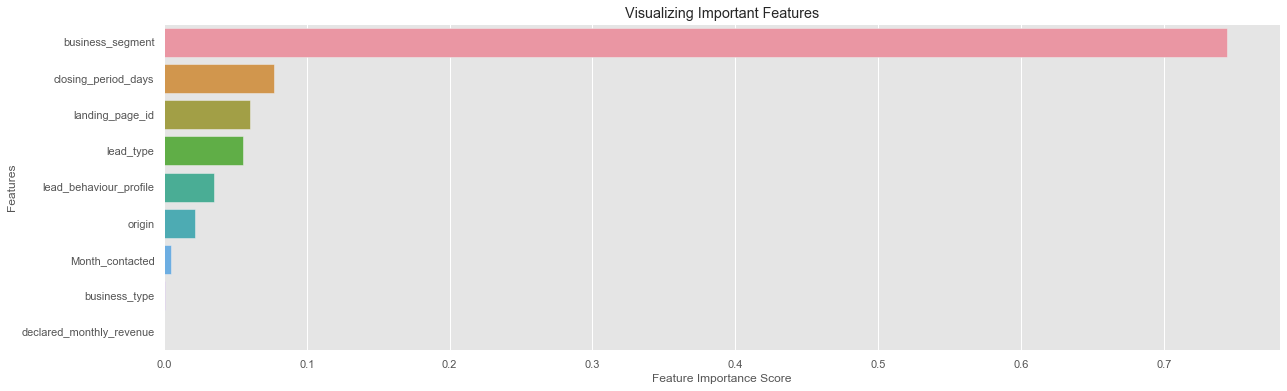

In [227]:
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

Above graph shows that some variables are much more important to our problem than others! Given that there are two variables with zero importance, it seems like we should be able to get rid of some of them without impacting performance.

In [228]:
features = ['business_segment','lead_type','lead_behaviour_profile',
            'landing_page_id','origin','Month_contacted','closing_period_days']
target = ['weekly_avg_revenue']

X = data[features].values
y = data[target].values
split_test_size = 0.20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split_test_size, random_state=42)

In [245]:
def grid_search(X, y):
    n_estimators = [int(x) for x in np.arange(200,2001,100)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.arange(10,101,10)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    
    random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
    
    rf = RandomForestRegressor()
    
    rf_grid = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                                   cv = 3, random_state=42)
    
    rf_grid.fit(X, y)
    
    return rf_grid

In [246]:
rf_grid_model = grid_search(X_train,y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

In [247]:
rf_predict_train = rf_grid_model.predict(X_train)
print("Training accuracy:")
metrics(y_train, rf_predict_train)

Training accuracy:
Mean absolute error: 19.1 kr.
Mean squared error: 3652.13 kr.


In [249]:
rf_predict_test = rf_grid_model.predict(X_test)
print("Test accuracy:")
metrics(y_test, rf_predict_test)

Test accuracy:
Mean absolute error: 17.73 kr.
Mean squared error: 566.98 kr.


In [224]:
feature_imp = pd.Series(rf_model.feature_importances_,index=features).sort_values(ascending=False)
feature_imp

business_segment            0.744112
closing_period_days         0.076947
landing_page_id             0.060376
lead_type                   0.055623
lead_behaviour_profile      0.035155
origin                      0.021837
Month_contacted             0.004965
business_type               0.000985
declared_monthly_revenue    0.000000
dtype: float64

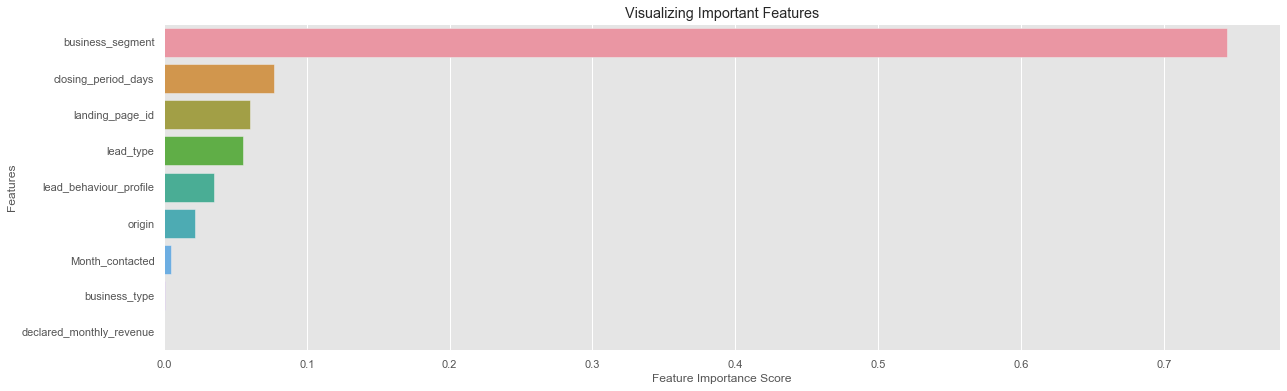

In [227]:
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

## <font color='blue'>2.4</font>: Conclusion

## <font color='blue'>Rest</font>: appendix

In [ ]:
#!curl https://raw.githubusercontent.com/nicodv/kmodes/master/examples/stocks.csv -o "stocks.csv"

In [ ]:
syms = np.genfromtxt('stocks.csv', dtype=str, delimiter=',')[:, 0]
X = np.genfromtxt('stocks.csv', dtype=object, delimiter=',')[:, 1:]

In [ ]:
X

In [ ]:
X[:, 0] = X[:, 0].astype(float)

In [ ]:
X[:,1:3] = X[:, 1:3].astype(str)

In [ ]:
X

In [ ]:
kproto = KPrototypes(n_clusters=4, init='Huang', n_init=5, verbose=1)

In [ ]:
clusters = kproto.fit_predict(X, categorical=[1, 2])

In [ ]:
clusters

In [ ]:
print(kproto.cluster_centroids_)

In [ ]:
print(kproto.cost_)
print(kproto.n_iter_)

In [ ]:
for s, c in zip(syms, clusters):
    print("Symbol: {}, cluster:{}".format(s, c))

In [ ]:
for i in set(kproto.labels_):
    index = kproto.labels_ == i
    plt.plot(X[index, 0], X[index, 1], 'o')
    plt.suptitle('Data points categorized with category score', fontsize=18)
    plt.xlabel('Category Score', fontsize=16)
    plt.ylabel('Category Type', fontsize=16)
plt.show()

In [ ]:
fig1, ax3 = plt.subplots()
scatter = ax3.scatter(syms, clusters, c=clusters, s=50)
ax3.set_xlabel('Data points')
ax3.set_ylabel('Cluster')
plt.colorbar(scatter)
ax3.set_title('Data points classifed according to known centers')
plt.show()

In [ ]:
result = zip(syms, kproto.labels_)
sortedR = sorted(result, key=lambda x: x[1])
print(sortedR)

### Calculating the total turnover throughout the history of the sellers

In [ ]:
closed_leads.head()

In [ ]:
all_orders = load_table("olist_order_items_dataset.csv")

In [ ]:
all_orders.head()

In [ ]:
len(all_orders)

##### Finding the total sales of the newly closed customers over time

In [ ]:
from scipy import stats

In [ ]:
len(all_orders.seller_id.unique())

Since there are more unique sellers on the platform than the ones closed within the last year, the data for the relevant closed_leads needs to be sorted. 

In [ ]:
newsellers_orders = all_orders.seller_id.isin(closed_leads.seller_id.unique())

In [ ]:
newsellers_orders = all_orders[newsellers_orders]

In [ ]:
newsellers_orders.head()

In [ ]:
newsellers_orders.loc[newsellers_orders.seller_id == "ba143b05f0110f0dc71ad71b4466ce92", "price"].sum()

In [ ]:
IDs = list(newsellers_orders.seller_id.unique())

In [ ]:
seller_turnover= {}
for id in IDs:
    

In [ ]:
newsellers_orders["sum_orders"] = newsellers_orders[newsellers_orders.]